In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf



Using TensorFlow backend.


In [129]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'train'
TEST_PATH = 'test'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 2
random.seed = seed
np.random.seed = seed
train_ids = [x[:-4] for x in os.listdir(TRAIN_PATH + '/images/tmp')]
test_ids = [x[:-4] for x in os.listdir(TEST_PATH + '/images/tmp')]

In [130]:
train_ids

['TCGA-AR-A1AS-01Z-00-DX1-4-6',
 'TCGA-49-4488-01Z-00-DX1-7-5',
 'TCGA-G9-6348-01Z-00-DX1-0-0',
 'TCGA-DK-A2I6-01A-01-TS1-1-6',
 'TCGA-E2-A14V-01Z-00-DX1-7-2',
 'TCGA-B0-5710-01Z-00-DX1-4-4',
 'TCGA-A7-A13E-01Z-00-DX1-5-1',
 'TCGA-21-5784-01Z-00-DX1-3-1',
 'TCGA-B0-5698-01Z-00-DX1-3-1',
 'TCGA-G9-6363-01Z-00-DX1-7-3',
 'TCGA-38-6178-01Z-00-DX1-2-3',
 'TCGA-A7-A13F-01Z-00-DX1-1-1',
 'TCGA-G9-6356-01Z-00-DX1-2-7',
 'TCGA-50-5931-01Z-00-DX1-2-2',
 'TCGA-G9-6336-01Z-00-DX1-6-7',
 'TCGA-G9-6348-01Z-00-DX1-2-2',
 'TCGA-49-4488-01Z-00-DX1-5-7',
 'TCGA-AR-A1AS-01Z-00-DX1-6-4',
 'TCGA-E2-A14V-01Z-00-DX1-5-0',
 'TCGA-DK-A2I6-01A-01-TS1-3-4',
 'TCGA-A7-A13E-01Z-00-DX1-7-3',
 'TCGA-B0-5710-01Z-00-DX1-6-6',
 'TCGA-21-5784-01Z-00-DX1-1-3',
 'TCGA-G9-6363-01Z-00-DX1-5-1',
 'TCGA-B0-5698-01Z-00-DX1-1-3',
 'TCGA-A7-A13F-01Z-00-DX1-3-3',
 'TCGA-38-6178-01Z-00-DX1-0-1',
 'TCGA-G9-6356-01Z-00-DX1-0-5',
 'TCGA-G9-6336-01Z-00-DX1-4-5',
 'TCGA-50-5931-01Z-00-DX1-0-0',
 'TCGA-E2-A14V-01Z-00-DX1-3-6',
 'TCGA-D

In [131]:
test_ids

['TCGA-RD-A8N9-01A-01-TS1-5-3',
 'TCGA-HE-7129-01Z-00-DX1-7-4',
 'TCGA-NH-A8F7-01A-01-TS1-7-7',
 'TCGA-HE-7129-01Z-00-DX1-5-6',
 'TCGA-RD-A8N9-01A-01-TS1-7-1',
 'TCGA-NH-A8F7-01A-01-TS1-5-5',
 'TCGA-NH-A8F7-01A-01-TS1-3-3',
 'TCGA-HE-7129-01Z-00-DX1-3-0',
 'TCGA-RD-A8N9-01A-01-TS1-1-7',
 'TCGA-NH-A8F7-01A-01-TS1-1-1',
 'TCGA-RD-A8N9-01A-01-TS1-3-5',
 'TCGA-HE-7129-01Z-00-DX1-1-2',
 'TCGA-HE-7129-01Z-00-DX1-1-3',
 'TCGA-RD-A8N9-01A-01-TS1-3-4',
 'TCGA-NH-A8F7-01A-01-TS1-1-0',
 'TCGA-RD-A8N9-01A-01-TS1-1-6',
 'TCGA-HE-7129-01Z-00-DX1-3-1',
 'TCGA-NH-A8F7-01A-01-TS1-3-2',
 'TCGA-NH-A8F7-01A-01-TS1-5-4',
 'TCGA-RD-A8N9-01A-01-TS1-7-0',
 'TCGA-HE-7129-01Z-00-DX1-5-7',
 'TCGA-NH-A8F7-01A-01-TS1-7-6',
 'TCGA-HE-7129-01Z-00-DX1-7-5',
 'TCGA-RD-A8N9-01A-01-TS1-5-2',
 'TCGA-NH-A8F7-01A-01-TS1-7-4',
 'TCGA-RD-A8N9-01A-01-TS1-5-0',
 'TCGA-HE-7129-01Z-00-DX1-7-7',
 'TCGA-NH-A8F7-01A-01-TS1-5-6',
 'TCGA-HE-7129-01Z-00-DX1-5-5',
 'TCGA-RD-A8N9-01A-01-TS1-7-2',
 'TCGA-HE-7129-01Z-00-DX1-3-3',
 'TCGA-R

In [134]:
from PIL import Image
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH
    if os.path.isfile(path + '/images/tmp/' + id_ + '.png'):
        img = imread(path + '/images/tmp/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

        mask_ = np.load(path + '/masks/tmp/' + id_ + '.npy')
        mask = np.expand_dims(mask_, axis=-1)
        Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 1537/1537 [00:03<00:00, 437.83it/s]


In [136]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH
    if os.path.isfile(path + '/images/tmp/' + id_ + '.png'):
        img = imread(path + '/images/tmp/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 385/385 [00:00<00:00, 536.84it/s]

Done!


/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


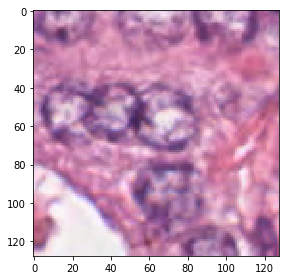

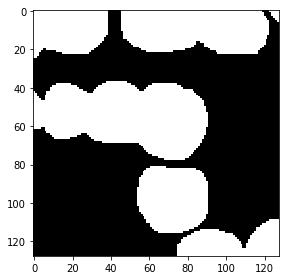

179

In [139]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
ix

In [140]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [141]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 128, 128, 8)  224         lambda_3[0][0]                   
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 128, 128, 8)  584         conv2d_32[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [142]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=4, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 1383 samples, validate on 154 samples
Epoch 1/30
1383/1383 [==============================] - 86s 62ms/step - loss: 0.4802 - mean_iou: 0.3672 - val_loss: 0.3852 - val_mean_iou: 0.4354

Epoch 00001: val_loss improved from inf to 0.38520, saving model to model-1.h5
Epoch 2/30
1383/1383 [==============================] - 86s 62ms/step - loss: 0.3369 - mean_iou: 0.4850 - val_loss: 0.3361 - val_mean_iou: 0.5205

Epoch 00002: val_loss improved from 0.38520 to 0.33613, saving model to model-1.h5
Epoch 3/30
1383/1383 [==============================] - 89s 64ms/step - loss: 0.3104 - mean_iou: 0.5419 - val_loss: 0.3197 - val_mean_iou: 0.5573

Epoch 00003: val_loss improved from 0.33613 to 0.31967, saving model to model-1.h5
Epoch 4/30
1383/1383 [==============================] - 87s 63ms/step - loss: 0.2921 - mean_iou: 0.5695 - val_loss: 0.3102 - val_mean_iou: 0.5797

Epoch 00004: val_loss improved from 0.31967 to 0.31015, saving model to model-1.h5
Epoch 5/30
1383/1383 [===============

In [147]:
# Predict on train, val and test
model = load_model('model-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)



385/385 [==============================] - 7s 18ms/step


In [148]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(preds_test[i])

/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


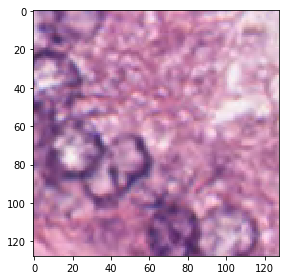

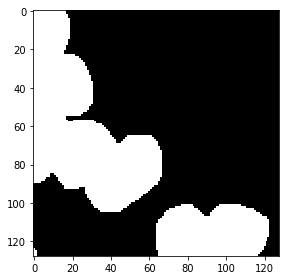

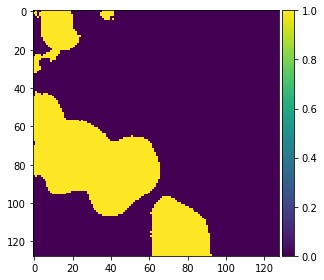

In [149]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


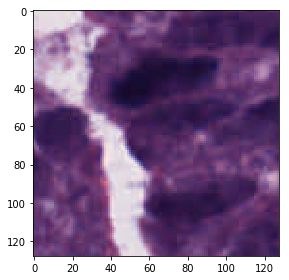

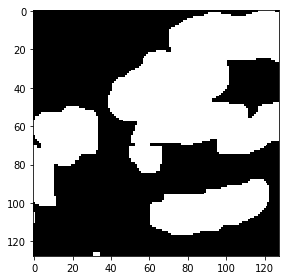

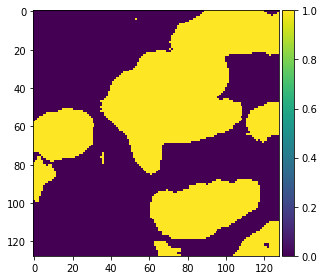

In [145]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [127]:
import imageio
from skimage.util.shape import view_as_windows
train_ids = [x[:-4] for x in os.listdir(TRAIN_PATH + '/images')]
test_ids = [x[:-4] for x in os.listdir(TEST_PATH + '/images')]
print('Splitting training img ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH
    if os.path.isfile(path + '/images/' + id_ + '.tif'):
        img = imread(path + '/images/' + id_ + '.tif')[:,:,:IMG_CHANNELS]
        window_shape = (128, 128,3)
        B = view_as_windows(img[50:950,50:950,:], window_shape,100)
        for i in range(0,8):
            for j in range(0,8):
                tmp_path=os.path.join(path,'images','tmp',id_ + "-%s-%s.png" % (i,j))
                imageio.imwrite(tmp_path, B[i,j,0])

        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

        mask_ = np.load(path + '/masks/' + id_ + '.npy')
        mask_window_shape = (128, 128)
        C = view_as_windows(mask_, mask_window_shape,100)
        for i in range(0,8):
            for j in range(0,8):
                tmp_path=os.path.join(path,'masks','tmp',id_ + "-%s-%s.npy" % (i,j))
                np.save(tmp_path, C[i,j])
        #mask = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
        #                             preserve_range=True), axis=-1)
        #Y_train[n] = mask

Splitting training img ... 


  0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2573: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  tile = decompress(tile)
/usr/local/lib/python3.6/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
100%|██████████| 26/26 [00:23<00:00,  1.13it/s]


In [128]:

train_ids = [x[:-4] for x in os.listdir(TRAIN_PATH + '/images')]
test_ids = [x[:-4] for x in os.listdir(TEST_PATH + '/images')]
print('Spliting test images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH
    if os.path.isfile(path + '/images/' + id_ + '.tif'):
        
        img = imread(path + '/images/' + id_ + '.tif')[:,:,:IMG_CHANNELS]
        window_shape = (128, 128,3)
        B = view_as_windows(img[50:950,50:950,:], window_shape,100)
        for i in range(0,8):
            for j in range(0,8):
                tmp_path=os.path.join(path,'images','tmp',id_ + "-%s-%s.png" % (i,j))
                imageio.imwrite(tmp_path, B[i,j,0])

        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

        mask_ = np.load(path + '/masks/' + id_ + '.npy')
        mask_window_shape = (128, 128)
        C = view_as_windows(mask_, mask_window_shape,100)
        for i in range(0,8):
            for j in range(0,8):
                tmp_path=os.path.join(path,'masks','tmp',id_ + "-%s-%s.npy" % (i,j))
                np.save(tmp_path, C[i,j])
    #mask = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
    #                             preserve_range=True), axis=-1)
    #Y_train[n] = mask

Spliting test images and masks ... 


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
100%|██████████| 8/8 [00:05<00:00,  1.58it/s]
